# Sensitivity of Fold-Change to $F$

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.bayes
import mut.viz
import tqdm
pboc = mut.viz.color_selector('pboc')

constants = mut.thermo.load_constants()
mut.viz.plotting_style()

In my analysis, I have found that at the extremes of fold-change the $\Delta F$ is poorly resolved and has aninteresting trend towards $\Delta F = 0$. I think this has something to do with the fact that when you approach the asymptotes of fold-change, the magnitude of the empirical $F$ gets very large. As a reminder, the empirical $F$ can be calculated from the fold-change data as

$$
F_\text{empirical} = \log \left( {1 \over \text{fold-change}} -1\right)
$$

# Generating a fake data set
We can generate a dataset in which fold-change measurements are normally distributed about a value prescribed by the theory. 

In [49]:
sigma = 0.05
n_reps = 10 
c_range = np.logspace(-2, 4, 200)
true_bohr = np.linspace(-10, 10, 200)
# mut.thermo.SimpleRepression(R=260, ep_r=-13.9, ka=139, ki=0.53, 
#                                         n_sites=2, ep_ai=4.5, 
#                                         effector_conc=c_range).bohr_parameter()
mut_bohr = true_bohr

# mut.thermo.SimpleRepression(R=260, ep_r=-13.9, ka=139, ki=0.53, 
#                                        n_sites=2, ep_ai=4.5, 
#                                        effector_conc=c_range).bohr_parameter()
dataset_fc = []
offset = 2
fc_mu = (1 + np.exp(-true_bohr))**-1
fc_mut = (1 + np.exp(-mut_bohr))**-1
for i, b in enumerate(true_bohr):
    mu = fc_mut[i]
    dataset = np.random.normal(mu, sigma, n_reps)
    df = pd.DataFrame(dataset.T, columns=['fold_change'])
    df['replicate'] = np.arange(n_reps)
    df['true_bohr'] = b
    dataset_fc.append(df)
dataset = pd.concat(dataset_fc)

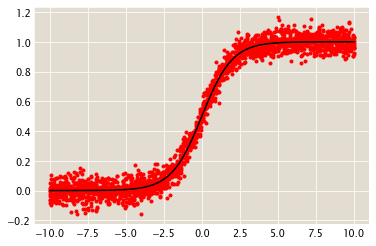

In [50]:

plt.plot(dataset['true_bohr'], dataset['fold_change'], 'r.')
# plt.plot(true_bohr, dataset.groupby(['true_bohr'])['fold_change'].mean(),'.')
plt.plot(true_bohr, fc_mu, 'k-')


In [56]:
# Load the stan model
model = mut.bayes.StanModel('../stan/empirical_F.stan' , force_compile=True)
stan_dfs = []
for g, d in dataset.groupby('true_bohr'):
    data_dict = {'N':len(d), 'ref_bohr':g, 'foldchange':d['fold_change']}
    fit, samples = model.sample(data_dict, iter=2000, control=dict(adapt_delta=0.9))
    
    # Correct past extrema
    extrema_idx = (samples['fc_mu'].values < samples['fc_sigma'].values) +\
                    ((1 - samples['fc_mu'].values) < samples['fc_sigma'].values)
    # Define the reference to use 
    lower_err = np.nan_to_num(g + -np.log((1/(samples['fc_sigma'])) - 1))
    upper_err = np.nan_to_num(g + -np.log((1/(1 - samples['fc_sigma'])) - 1))
    corr = (lower_err + upper_err) * extrema_idx
    samples['corr'] = corr
    samples['bohr'] =  -np.log((1/samples['fc_mu']) - 1)
    samples['delta_bohr'] = g - samples['bohr']
    samples['delta_bohr_corrected'] = samples['delta_bohr'] + samples['corr']
    stats = mut.stats.compute_statistics(samples, varnames=['fc_mu', 'fc_sigma',
                                                           'bohr', 'delta_bohr_corrected',
                                                            'delta_bohr', 'corr'],
                                        logprob_name='lp__')
    stats['true_bohr'] = g
    stats['fc_mu_std'] = np.std(samples['fc_mu'])
    stan_dfs.append(stats)
stats = pd.concat(stan_dfs)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_985a03cc947fc7b61fecfd0fc99c21f8 NOW.


Precompiled model not found. Compiling model...


/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpbf2yfdp_/stanfit4anon_model_985a03cc947fc7b61fecfd0fc99c21f8_900101854402518913.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


finished!


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


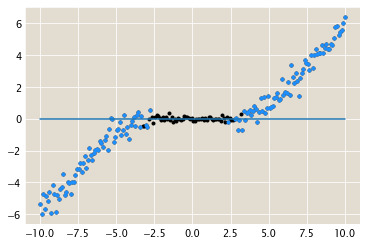

In [58]:
dF = stats[stats['parameter']=='delta_bohr']
_fc_mu = stats[stats['parameter']=='fc_mu']['median'].values
bohr = stats[stats['parameter']=='bohr']['median'].values
fc_sigma = stats[stats['parameter']=='fc_sigma']['median'].values
ddF =  stats[stats['parameter']=='delta_bohr_corrected']
fc_ref = (1 + np.exp(-true_bohr))**-1

# Plot the ground truth. 
ref1 = np.log(fc_sigma**-1 - 1)
# plt.plot(true_bohr, true_bohr - true_bohr + offset, color='dodgerblue')
idx = _fc_mu < fc_sigma
idx2 = (1 - _fc_mu) < fc_sigma

plt.plot(true_bohr, dF['median'], '.', color='k') 
plt.plot(true_bohr[idx], dF['median'].values[idx], '.', color='dodgerblue')
plt.plot(true_bohr[idx2],dF['median'].values[idx2], '.', color='dodgerblue')
plt.plot(true_bohr,  true_bohr - mut_bohr)


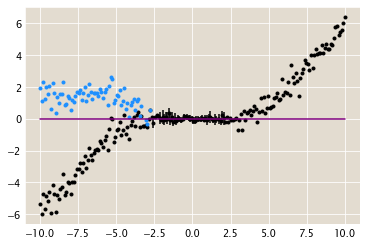

In [59]:
max_ind =  np.max(np.where(_fc_mu < fc_sigma))
# min_ind = np.min(np.where((1 - _fc_mu < fc_sigma)))

plt.plot(true_bohr, dF['median'], 'k.')
plt.vlines(true_bohr, dF['hpd_min'], dF['hpd_max'], 'k')
plt.plot(true_bohr[idx], dF['median'][idx] - (true_bohr[idx] - true_bohr[max_ind]), '.', color='dodgerblue')
plt.plot(true_bohr, true_bohr - mut_bohr, '-', color='purple')

In [29]:
np.log(fc_sigma[idx2]**-1 -1)/bohr[idx2]

array([], dtype=float64)

In [252]:
true_bohr[idx2] - true_bohr[min_ind-

SyntaxError: unexpected EOF while parsing (<ipython-input-252-d45a954c6738>, line 1)

In [224]:
true_bohr[min_ind]

1.3180784623079536

In [225]:
true_bohr - true_bohr[max_ind]

array([-6.21430309, -6.21429103, -6.21427543, -6.21425528, -6.21422922,
       -6.21419552, -6.21415192, -6.21409548, -6.21402239, -6.21392765,
       -6.21380472, -6.213645  , -6.21343715, -6.21316606, -6.21281157,
       -6.21234643, -6.21173354, -6.21092177, -6.20983976, -6.20838652,
       -6.20641711, -6.20372049, -6.19998508, -6.19474543, -6.18729954,
       -6.17658278, -6.16098013, -6.13805938, -6.10422239, -6.05432005,
       -5.98138282, -5.87678356, -5.73126231, -5.5370226 , -5.29033985,
       -4.99328586, -4.65339641, -4.28155206, -3.88948246, -3.48806198,
       -3.08663332, -2.69300389, -2.31368995, -1.95414288, -1.61885345,
       -1.31133278, -1.0340216 , -0.78819895, -0.57395571, -0.39027152,
       -0.23519702, -0.10611038,  0.        ,  0.08627315,  0.15576518,
        0.21130383,  0.2554052 ,  0.29024101,  0.31764156,  0.33912098,
        0.35591359,  0.36901423,  0.37921757,  0.38715398,  0.39332081,
        0.39810882,  0.40182398,  0.4047053 ,  0.40693909,  0.40

In [226]:

np.where(_fc_mu < fc_sigma)

(array([], dtype=int64),)

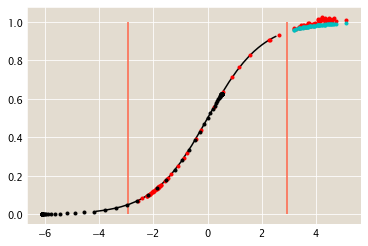

In [227]:
plt.plot(true_bohr, (1 + np.exp(-true_bohr))**-1, 'k-')
plt.plot(bohr, dataset.groupby(['true_bohr'])['fold_change'].mean(), 'r.')
plt.plot(bohr[idx], dataset.groupby(['true_bohr'])['fold_change'].mean()[idx], 'w.')
plt.vlines(np.log(sigma**-1 -1), 0, 1, color='tomato')
plt.vlines(-np.log(sigma**-1 -1), 0, 1, color='tomato')
plt.plot(true_bohr - offset, (1 + np.exp(-true_bohr+offset))**-1, 'k.')

plt.plot(bohr[idx], _fc_mu[idx], 'c.')
plt.plot(bohr[idx2], _fc_mu[idx2], 'c.')

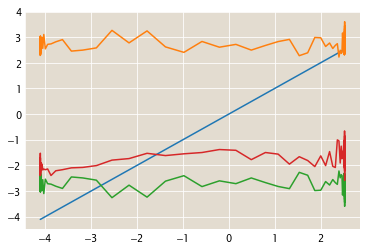

In [228]:
plt.plot(true_bohr, true_bohr)
plt.plot(true_bohr, np.log(fc_sigma**-1 -1))
plt.plot(true_bohr, -np.log(fc_sigma**-1 -1))
plt.plot(true_bohr, dF['median'])


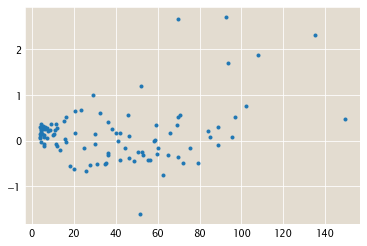

In [60]:
a = (_fc_mu - _fc_mu**2)**-1
b = a[:-1] * np.diff(_fc_mu)
plt.plot(a[:-1], b, '.')